# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.16 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [5]:
import numpy as np
import random
import time
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment

In [6]:
seed = 3

In [7]:
# DDPG function
def ddpg(num_episodes=10000, max_t=1000, print_every=1, actor_weights_name='actor.pth', critic_weights_name='critic.pth'):
    """Deep Deterministic Policy Gradient
    
    Params
    ======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    print_every (int): interval to display results
    
    """
    max_scores = [] # list of mean scores from each episode
    moving_avgs = [] # list of moving averages
    best_score = -np.inf
    scores_window = deque(maxlen=100) # mean score from last 100 episodes
    initial_time = time.time()
    
    for i_episode in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset environment
        states = env_info.vector_observations # get current state for each observations
        scores = np.zeros(num_agents) # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True) # select an action
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations # get next state (for each agent)
            rewards = env_info.rewards # get reward (for each agent)
            dones = env_info.local_done # see if episode finished
            # perform learning step
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        duration = time.time() - start_time
        max_scores.append(np.max(scores)) # save max score for each episode
        scores_window.append(max_scores[-1]) # save max score to window
        moving_avgs.append(np.mean(scores_window)) # save moving average
        
        if i_episode % print_every == 0:
            print("\rEpisode {} ({}s)\tMax score: {:.3f}\tMoving Avg: {:.3f}"\
                  .format(i_episode, round(duration), max_scores[-1], moving_avgs[-1]))
        if moving_avgs[-1] >= 0.5:
            print("\nEnvironment solved in {:d} episodes.\tAverage score: {:.3f}\tTotal training time: {}s"\
                 .format(i_episode, moving_avgs[-1], (time.time()-initial_time)))
            torch.save(agent.actor_local.state_dict(), actor_weights_name)
            torch.save(agent.critic_local.state_dict(), critic_weights_name)
            break
            
    return max_scores, moving_avgs
    

In [8]:
# start the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)

In [9]:
scores, avgs = ddpg(actor_weights_name ='actor_tennis.pth', critic_weights_name='critic_tennis.pth')

Episode 1 (0s)	Max score: 0.000	Moving Avg: 0.000
Episode 2 (0s)	Max score: 0.090	Moving Avg: 0.045
Episode 3 (0s)	Max score: 0.000	Moving Avg: 0.030
Episode 4 (0s)	Max score: 0.000	Moving Avg: 0.023
Episode 5 (0s)	Max score: 0.000	Moving Avg: 0.018
Episode 6 (0s)	Max score: 0.000	Moving Avg: 0.015
Episode 7 (0s)	Max score: 0.000	Moving Avg: 0.013
Episode 8 (0s)	Max score: 0.000	Moving Avg: 0.011
Episode 9 (2s)	Max score: 0.000	Moving Avg: 0.010
Episode 10 (4s)	Max score: 0.000	Moving Avg: 0.009
Episode 11 (4s)	Max score: 0.000	Moving Avg: 0.008
Episode 12 (4s)	Max score: 0.000	Moving Avg: 0.008
Episode 13 (4s)	Max score: 0.000	Moving Avg: 0.007
Episode 14 (4s)	Max score: 0.000	Moving Avg: 0.006
Episode 15 (4s)	Max score: 0.000	Moving Avg: 0.006
Episode 16 (4s)	Max score: 0.000	Moving Avg: 0.006
Episode 17 (4s)	Max score: 0.000	Moving Avg: 0.005
Episode 18 (4s)	Max score: 0.000	Moving Avg: 0.005
Episode 19 (20s)	Max score: 0.100	Moving Avg: 0.010
Episode 20 (4s)	Max score: 0.000	Moving

Episode 160 (10s)	Max score: 0.100	Moving Avg: 0.079
Episode 161 (27s)	Max score: 0.200	Moving Avg: 0.081
Episode 162 (7s)	Max score: 0.000	Moving Avg: 0.081
Episode 163 (14s)	Max score: 0.100	Moving Avg: 0.082
Episode 164 (78s)	Max score: 0.600	Moving Avg: 0.087
Episode 165 (9s)	Max score: 0.100	Moving Avg: 0.087
Episode 166 (30s)	Max score: 0.200	Moving Avg: 0.088
Episode 167 (21s)	Max score: 0.200	Moving Avg: 0.089
Episode 168 (10s)	Max score: 0.100	Moving Avg: 0.090
Episode 169 (13s)	Max score: 0.100	Moving Avg: 0.091
Episode 170 (16s)	Max score: 0.100	Moving Avg: 0.091
Episode 171 (41s)	Max score: 0.300	Moving Avg: 0.093
Episode 172 (16s)	Max score: 0.100	Moving Avg: 0.094
Episode 173 (10s)	Max score: 0.100	Moving Avg: 0.095
Episode 174 (6s)	Max score: 0.090	Moving Avg: 0.094
Episode 175 (10s)	Max score: 0.100	Moving Avg: 0.095
Episode 176 (16s)	Max score: 0.100	Moving Avg: 0.095
Episode 177 (17s)	Max score: 0.100	Moving Avg: 0.095
Episode 178 (10s)	Max score: 0.100	Moving Avg: 0.

Episode 316 (15s)	Max score: 0.100	Moving Avg: 0.167
Episode 317 (26s)	Max score: 0.200	Moving Avg: 0.168
Episode 318 (22s)	Max score: 0.200	Moving Avg: 0.166
Episode 319 (39s)	Max score: 0.300	Moving Avg: 0.167
Episode 320 (27s)	Max score: 0.200	Moving Avg: 0.168
Episode 321 (10s)	Max score: 0.100	Moving Avg: 0.168
Episode 322 (16s)	Max score: 0.100	Moving Avg: 0.165
Episode 323 (44s)	Max score: 0.400	Moving Avg: 0.169
Episode 324 (39s)	Max score: 0.300	Moving Avg: 0.171
Episode 325 (21s)	Max score: 0.200	Moving Avg: 0.172
Episode 326 (15s)	Max score: 0.100	Moving Avg: 0.172
Episode 327 (15s)	Max score: 0.100	Moving Avg: 0.172
Episode 328 (38s)	Max score: 0.400	Moving Avg: 0.176
Episode 329 (32s)	Max score: 0.300	Moving Avg: 0.178
Episode 330 (20s)	Max score: 0.200	Moving Avg: 0.179
Episode 331 (50s)	Max score: 0.400	Moving Avg: 0.182
Episode 332 (27s)	Max score: 0.200	Moving Avg: 0.183
Episode 333 (33s)	Max score: 0.300	Moving Avg: 0.184
Episode 334 (28s)	Max score: 0.200	Moving Avg:

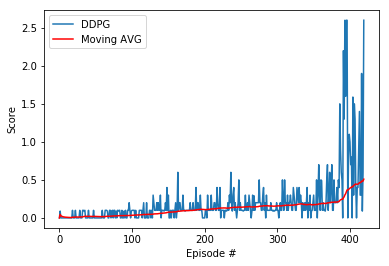

In [10]:
# plot scores across episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()


In [11]:
env.close()